In [1]:
import os.path as osp

import torch
from tqdm import tqdm
import numpy as np

from torch_geometric.nn import LightGCN
from torch_geometric.utils import degree, train_test_split_edges

In [2]:
import os
import os.path as osp
from typing import Callable, Optional

import pandas as pd
from torch_geometric.data import HeteroData, InMemoryDataset, download_url, extract_zip

class MovieLens100K(InMemoryDataset):
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        force_reload: bool = False,
    ):
        super().__init__(root, transform, pre_transform, force_reload=force_reload)
        self.load(self.processed_paths[0], data_cls=HeteroData)

    @property
    def raw_file_names(self) -> list:
        return ['u.item', 'u.user', 'u1.base', 'u1.test']

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        path = download_url(self.url, self.root)
        extract_zip(path, self.root)
        os.remove(path)
        folder = osp.join(self.root, 'ml-100k')
        os.rename(folder, self.raw_dir)

    def process(self) -> None:
        data = HeteroData()

        # Process users:
        user_df = pd.read_csv(
            osp.join(self.raw_dir, 'u.user'),
            sep='|',
            header=None,
            names=['userId', 'age', 'gender', 'occupation', 'zipCode'],
            encoding='ISO-8859-1',
        )
        data['user'].num_nodes = len(user_df)

        # Process movies:
        movie_df = pd.read_csv(
            osp.join(self.raw_dir, 'u.item'),
            sep='|',
            header=None,
            names=[
                "movieId", "title", "releaseDate", "videoReleaseDate", "IMDb URL",
                "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
                "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
                "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
            ],
            encoding='ISO-8859-1',
            usecols=['movieId'],
        )
        data['movie'].num_nodes = len(movie_df)

        # Process edges for training and testing:
        edge_attrs = ['edge_index', 'edge_label_index']
        for edge_attr, raw_path in zip(edge_attrs, ['u1.base', 'u1.test']):
            edges_df = pd.read_csv(
                osp.join(self.raw_dir, raw_path),
                sep='\t',
                header=None,
                names=['userId', 'movieId', 'rating', 'timestamp'],
            )
            src = edges_df['userId'].values - 1  # Adjusting index to start from 0
            dst = edges_df['movieId'].values - 1  # Adjusting index to start from 0
            index = torch.tensor(np.array([src, dst]))
            data['user', 'rates', 'movie'][edge_attr] = index
            if edge_attr == 'edge_index':
                data['movie', 'rated_by', 'user'][edge_attr] = index.flip([0])

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        self.save([data], self.processed_paths[0])


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.realpath('projectFINAL.ipynb')), '', 'data', 'MovieLens')
dataset = MovieLens100K(path)
data = dataset[0]
num_users, num_movies = data['user'].num_nodes, data['movie'].num_nodes
data = data.to_homogeneous().to(device)
print(data)

Data(edge_index=[2, 160000], edge_label_index=[2, 20000], node_type=[2625], edge_type=[160000])


In [4]:
from torch import Tensor
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import is_sparse, to_edge_index
from typing import List

class ResidualLightGCN(LightGCN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_embeddings_per_layer(
        self,
        edge_index: Adj,
        edge_weight: OptTensor = None,
    ) -> List[Tensor]:
        """Returns the embeddings of nodes in the graph for each layer."""
        x = self.embedding.weight
        embeddings = [x]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, edge_weight)
            embeddings.append(x)

        return embeddings

    def forward(
        self,
        edge_index: Adj,
        edge_label_index: OptTensor = None,
        edge_weight: OptTensor = None,
    ) -> Tensor:
        r"""Computes rankings for pairs of nodes.

        Args:
            edge_index (torch.Tensor or SparseTensor): Edge tensor specifying
                the connectivity of the graph.
            edge_label_index (torch.Tensor, optional): Edge tensor specifying
                the node pairs for which to compute rankings or probabilities.
                If :obj:`edge_label_index` is set to :obj:`None`, all edges in
                :obj:`edge_index` will be used instead. (default: :obj:`None`)
            edge_weight (torch.Tensor, optional): The weight of each edge in
                :obj:`edge_index`. (default: :obj:`None`)
        """
        if edge_label_index is None:
            if is_sparse(edge_index):
                edge_label_index, _ = to_edge_index(edge_index)
            else:
                edge_label_index = edge_index

        embeddings = self.get_embeddings_per_layer(edge_index, edge_weight)

        pred = torch.zeros(edge_label_index.size(1), device=edge_index.device)
        for i, alpha in enumerate(self.alpha):
            out_src = embeddings[i][edge_label_index[0]]
            out_dst = embeddings[i][edge_label_index[1]]
            pred += alpha * (out_src * out_dst).sum(dim=-1)

        return pred
    
    def recommend(
        self,
        edge_index: Adj,
        edge_weight: OptTensor = None,
        src_index: OptTensor = None,
        dst_index: OptTensor = None,
        k: int = 1,
        sorted: bool = True,
    ) -> Tensor:
        r"""Get top-:math:`k` recommendations for nodes in :obj:`src_index`.

        Args:
            edge_index (torch.Tensor or SparseTensor): Edge tensor specifying
                the connectivity of the graph.
            edge_weight (torch.Tensor, optional): The weight of each edge in
                :obj:`edge_index`. (default: :obj:`None`)
            src_index (torch.Tensor, optional): Node indices for which
                recommendations should be generated.
                If set to :obj:`None`, all nodes will be used.
                (default: :obj:`None`)
            dst_index (torch.Tensor, optional): Node indices which represent
                the possible recommendation choices.
                If set to :obj:`None`, all nodes will be used.
                (default: :obj:`None`)
            k (int, optional): Number of recommendations. (default: :obj:`1`)
            sorted (bool, optional): Whether to sort the recommendations
                by score. (default: :obj:`True`)
        """
        embeddings = self.get_embeddings_per_layer(edge_index, edge_weight)

        out_src = out_dst = sum(alpha * emb for alpha, emb in zip(self.alpha, embeddings))

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1, sorted=sorted).indices

        if dst_index is not None:
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


In [5]:
# Split edges into train/val/test sets
data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)
print(data)

train_edge_index = data.train_pos_edge_index
val_edge_index = data.val_pos_edge_index
test_edge_index = data.test_pos_edge_index

batch_size = 512
mask = train_edge_index[0] < train_edge_index[1]
train_edge_label_index = train_edge_index[:, mask]
train_loader = torch.utils.data.DataLoader(
    range(train_edge_label_index.size(1)),
    shuffle=True,
    batch_size=batch_size,
)

model = ResidualLightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=64,
    num_layers=2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Data(edge_label_index=[2, 20000], node_type=[2625], edge_type=[160000], val_pos_edge_index=[2, 8000], test_pos_edge_index=[2, 8000], train_pos_edge_index=[2, 128000], train_neg_adj_mask=[2625, 2625], val_neg_edge_index=[2, 8000], test_neg_edge_index=[2, 8000])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [6]:
def train():
    model.train()
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        pos_edge_label_index = train_edge_label_index[:, index]
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (index.numel(), ), device=device)
        ], dim=0)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(data.train_pos_edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples

@torch.no_grad()
def test(edge_index, k: int):
    model.eval()
    embeddings_per_layer = model.get_embeddings_per_layer(data.train_pos_edge_index)
    num_layers = len(embeddings_per_layer)

    emb = sum(model.alpha[i] * embeddings_per_layer[i] for i in range(num_layers))
    user_emb, movie_emb = emb[:num_users], emb[num_users:]

    precision = recall = total_examples = total_loss = 0
    for start in range(0, num_users, batch_size):
        end = start + batch_size
        logits = user_emb[start:end] @ movie_emb.t()

        mask = ((train_edge_label_index[0] >= start) &
                (train_edge_label_index[0] < end))
        logits[train_edge_label_index[0, mask] - start,
               train_edge_label_index[1, mask] - num_users] = float('-inf')

        ground_truth = torch.zeros_like(logits, dtype=torch.bool)
        mask = ((edge_index[0] >= start) & (edge_index[0] < end))
        ground_truth[edge_index[0, mask] - start,
                     edge_index[1, mask] - num_users] = True
        node_count = degree(edge_index[0, mask] - start,
                            num_nodes=logits.size(0))

        topk_index = logits.topk(k, dim=-1).indices
        isin_mat = ground_truth.gather(1, topk_index)

        precision += float((isin_mat.sum(dim=-1) / k).sum())
        recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
        total_examples += int((node_count > 0).sum())

        # Calculate loss
        pos_edge_index = edge_index[:, mask]
        neg_edge_index = torch.stack([
            pos_edge_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (pos_edge_index.size(1),), device=device)
        ], dim=0)
        eval_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)

        pos_rank, neg_rank = model(data.train_pos_edge_index, eval_edge_index).chunk(2)
        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=eval_edge_index.unique(),
        )
        total_loss += float(loss) * pos_rank.numel()

    return total_loss / total_examples, precision / total_examples, recall / total_examples


In [7]:
patience = 10  # Number of epochs to wait for improvement
best_val_recall = 0
best_epoch = 0
patience_counter = 0
best_model_path = 'best_model_ResidualLightGCN.pth'

train_losses = []
val_losses = []

n_epochs = 50

for epoch in range(1, n_epochs + 1):
    loss = train()
    val_loss, val_precision, val_recall = test(val_edge_index, k=20)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Precision@20: '
          f'{val_precision:.4f}, Val Recall@20: {val_recall:.4f}, '
          f'Val Loss: {val_loss:.4f}')
    
    train_losses.append(loss)
    val_losses.append(val_loss)
    
    # Early stopping logic
    if val_recall > best_val_recall:
        best_val_recall = val_recall
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}. Best epoch: {best_epoch} with Val Recall@20: {best_val_recall:.4f}')
        break
    


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:05<00:00, 21.03it/s]


Epoch: 001, Train Loss: 0.6859, Val Precision@20: 0.0604, Val Recall@20: 0.1738, Val Loss: 5.7493


100%|██████████| 125/125 [00:07<00:00, 17.36it/s]


Epoch: 002, Train Loss: 0.5323, Val Precision@20: 0.0590, Val Recall@20: 0.1662, Val Loss: 3.8792


100%|██████████| 125/125 [00:05<00:00, 22.89it/s]


Epoch: 003, Train Loss: 0.4193, Val Precision@20: 0.0608, Val Recall@20: 0.1756, Val Loss: 3.5967


100%|██████████| 125/125 [00:05<00:00, 21.82it/s]


Epoch: 004, Train Loss: 0.4024, Val Precision@20: 0.0655, Val Recall@20: 0.1958, Val Loss: 3.5381


100%|██████████| 125/125 [00:05<00:00, 20.91it/s]


Epoch: 005, Train Loss: 0.3880, Val Precision@20: 0.0708, Val Recall@20: 0.2144, Val Loss: 3.3663


100%|██████████| 125/125 [00:05<00:00, 21.34it/s]


Epoch: 006, Train Loss: 0.3749, Val Precision@20: 0.0737, Val Recall@20: 0.2251, Val Loss: 3.2502


100%|██████████| 125/125 [00:05<00:00, 21.57it/s]


Epoch: 007, Train Loss: 0.3637, Val Precision@20: 0.0760, Val Recall@20: 0.2311, Val Loss: 3.1538


100%|██████████| 125/125 [00:05<00:00, 21.47it/s]


Epoch: 008, Train Loss: 0.3514, Val Precision@20: 0.0776, Val Recall@20: 0.2333, Val Loss: 3.0479


100%|██████████| 125/125 [00:05<00:00, 21.37it/s]


Epoch: 009, Train Loss: 0.3462, Val Precision@20: 0.0792, Val Recall@20: 0.2339, Val Loss: 3.0877


100%|██████████| 125/125 [00:05<00:00, 21.08it/s]


Epoch: 010, Train Loss: 0.3406, Val Precision@20: 0.0803, Val Recall@20: 0.2343, Val Loss: 3.0725


100%|██████████| 125/125 [00:05<00:00, 20.99it/s]


Epoch: 011, Train Loss: 0.3329, Val Precision@20: 0.0812, Val Recall@20: 0.2348, Val Loss: 3.0337


100%|██████████| 125/125 [00:06<00:00, 19.99it/s]


Epoch: 012, Train Loss: 0.3284, Val Precision@20: 0.0819, Val Recall@20: 0.2365, Val Loss: 3.0810


100%|██████████| 125/125 [00:05<00:00, 20.92it/s]


Epoch: 013, Train Loss: 0.3282, Val Precision@20: 0.0817, Val Recall@20: 0.2362, Val Loss: 3.0175


100%|██████████| 125/125 [00:05<00:00, 21.68it/s]


Epoch: 014, Train Loss: 0.3188, Val Precision@20: 0.0816, Val Recall@20: 0.2371, Val Loss: 2.8836


100%|██████████| 125/125 [00:05<00:00, 20.96it/s]


Epoch: 015, Train Loss: 0.3139, Val Precision@20: 0.0814, Val Recall@20: 0.2352, Val Loss: 2.9106


100%|██████████| 125/125 [00:05<00:00, 21.17it/s]


Epoch: 016, Train Loss: 0.3085, Val Precision@20: 0.0834, Val Recall@20: 0.2380, Val Loss: 2.8944


100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


Epoch: 017, Train Loss: 0.3057, Val Precision@20: 0.0846, Val Recall@20: 0.2436, Val Loss: 2.8630


100%|██████████| 125/125 [00:06<00:00, 20.83it/s]


Epoch: 018, Train Loss: 0.3046, Val Precision@20: 0.0853, Val Recall@20: 0.2443, Val Loss: 2.8435


100%|██████████| 125/125 [00:05<00:00, 21.34it/s]


Epoch: 019, Train Loss: 0.3002, Val Precision@20: 0.0855, Val Recall@20: 0.2457, Val Loss: 2.8596


100%|██████████| 125/125 [00:06<00:00, 20.63it/s]


Epoch: 020, Train Loss: 0.2972, Val Precision@20: 0.0863, Val Recall@20: 0.2480, Val Loss: 2.8314


100%|██████████| 125/125 [00:06<00:00, 20.74it/s]


Epoch: 021, Train Loss: 0.2942, Val Precision@20: 0.0869, Val Recall@20: 0.2517, Val Loss: 2.7440


100%|██████████| 125/125 [00:06<00:00, 20.54it/s]


Epoch: 022, Train Loss: 0.2906, Val Precision@20: 0.0873, Val Recall@20: 0.2519, Val Loss: 2.7612


100%|██████████| 125/125 [00:06<00:00, 20.25it/s]


Epoch: 023, Train Loss: 0.2881, Val Precision@20: 0.0873, Val Recall@20: 0.2558, Val Loss: 2.7568


100%|██████████| 125/125 [00:06<00:00, 19.98it/s]


Epoch: 024, Train Loss: 0.2859, Val Precision@20: 0.0879, Val Recall@20: 0.2560, Val Loss: 2.7358


100%|██████████| 125/125 [00:06<00:00, 19.95it/s]


Epoch: 025, Train Loss: 0.2851, Val Precision@20: 0.0882, Val Recall@20: 0.2592, Val Loss: 2.7532


100%|██████████| 125/125 [00:06<00:00, 19.24it/s]


Epoch: 026, Train Loss: 0.2807, Val Precision@20: 0.0881, Val Recall@20: 0.2583, Val Loss: 2.7743


100%|██████████| 125/125 [00:06<00:00, 20.04it/s]


Epoch: 027, Train Loss: 0.2786, Val Precision@20: 0.0888, Val Recall@20: 0.2599, Val Loss: 2.7715


100%|██████████| 125/125 [00:06<00:00, 19.06it/s]


Epoch: 028, Train Loss: 0.2799, Val Precision@20: 0.0894, Val Recall@20: 0.2617, Val Loss: 2.6938


100%|██████████| 125/125 [00:06<00:00, 18.88it/s]


Epoch: 029, Train Loss: 0.2737, Val Precision@20: 0.0904, Val Recall@20: 0.2639, Val Loss: 2.6950


100%|██████████| 125/125 [00:06<00:00, 18.45it/s]


Epoch: 030, Train Loss: 0.2715, Val Precision@20: 0.0907, Val Recall@20: 0.2637, Val Loss: 2.7108


100%|██████████| 125/125 [00:06<00:00, 18.70it/s]


Epoch: 031, Train Loss: 0.2667, Val Precision@20: 0.0917, Val Recall@20: 0.2642, Val Loss: 2.6820


100%|██████████| 125/125 [00:07<00:00, 16.71it/s]


Epoch: 032, Train Loss: 0.2649, Val Precision@20: 0.0915, Val Recall@20: 0.2668, Val Loss: 2.6455


100%|██████████| 125/125 [00:07<00:00, 17.13it/s]


Epoch: 033, Train Loss: 0.2634, Val Precision@20: 0.0923, Val Recall@20: 0.2690, Val Loss: 2.7577


100%|██████████| 125/125 [00:07<00:00, 15.78it/s]


Epoch: 034, Train Loss: 0.2596, Val Precision@20: 0.0922, Val Recall@20: 0.2689, Val Loss: 2.6954


100%|██████████| 125/125 [00:07<00:00, 17.38it/s]


Epoch: 035, Train Loss: 0.2613, Val Precision@20: 0.0925, Val Recall@20: 0.2688, Val Loss: 2.5967


100%|██████████| 125/125 [00:08<00:00, 14.75it/s]


Epoch: 036, Train Loss: 0.2589, Val Precision@20: 0.0928, Val Recall@20: 0.2688, Val Loss: 2.6710


100%|██████████| 125/125 [00:07<00:00, 16.92it/s]


Epoch: 037, Train Loss: 0.2569, Val Precision@20: 0.0937, Val Recall@20: 0.2743, Val Loss: 2.6554


100%|██████████| 125/125 [00:08<00:00, 15.11it/s]


Epoch: 038, Train Loss: 0.2544, Val Precision@20: 0.0939, Val Recall@20: 0.2740, Val Loss: 2.7044


100%|██████████| 125/125 [00:07<00:00, 17.77it/s]


Epoch: 039, Train Loss: 0.2506, Val Precision@20: 0.0935, Val Recall@20: 0.2734, Val Loss: 2.6951


100%|██████████| 125/125 [00:06<00:00, 18.14it/s]


Epoch: 040, Train Loss: 0.2480, Val Precision@20: 0.0938, Val Recall@20: 0.2745, Val Loss: 2.7074


100%|██████████| 125/125 [00:07<00:00, 17.33it/s]


Epoch: 041, Train Loss: 0.2473, Val Precision@20: 0.0936, Val Recall@20: 0.2745, Val Loss: 2.6684


100%|██████████| 125/125 [00:06<00:00, 17.94it/s]


Epoch: 042, Train Loss: 0.2455, Val Precision@20: 0.0932, Val Recall@20: 0.2722, Val Loss: 2.6531


100%|██████████| 125/125 [00:06<00:00, 17.94it/s]


Epoch: 043, Train Loss: 0.2440, Val Precision@20: 0.0938, Val Recall@20: 0.2736, Val Loss: 2.7046


100%|██████████| 125/125 [00:07<00:00, 17.58it/s]


Epoch: 044, Train Loss: 0.2404, Val Precision@20: 0.0947, Val Recall@20: 0.2785, Val Loss: 2.7051


100%|██████████| 125/125 [00:08<00:00, 14.72it/s]


Epoch: 045, Train Loss: 0.2421, Val Precision@20: 0.0946, Val Recall@20: 0.2775, Val Loss: 2.6671


100%|██████████| 125/125 [00:07<00:00, 15.88it/s]


Epoch: 046, Train Loss: 0.2361, Val Precision@20: 0.0946, Val Recall@20: 0.2785, Val Loss: 2.6803


100%|██████████| 125/125 [00:07<00:00, 17.31it/s]


Epoch: 047, Train Loss: 0.2348, Val Precision@20: 0.0953, Val Recall@20: 0.2825, Val Loss: 2.6781


100%|██████████| 125/125 [00:07<00:00, 16.02it/s]


Epoch: 048, Train Loss: 0.2357, Val Precision@20: 0.0949, Val Recall@20: 0.2795, Val Loss: 2.7070


100%|██████████| 125/125 [00:07<00:00, 16.92it/s]


Epoch: 049, Train Loss: 0.2306, Val Precision@20: 0.0945, Val Recall@20: 0.2792, Val Loss: 2.7103


100%|██████████| 125/125 [00:07<00:00, 17.20it/s]


Epoch: 050, Train Loss: 0.2303, Val Precision@20: 0.0950, Val Recall@20: 0.2814, Val Loss: 2.6434


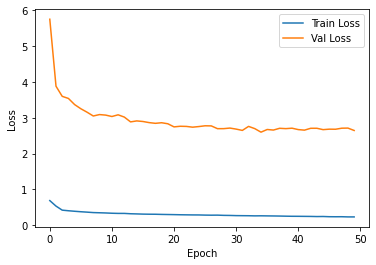

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
model.load_state_dict(torch.load(best_model_path))
test_loss, test_precision, test_recall = test(test_edge_index, k=20)
print(f'Test Precision@20: {test_precision:.4f}, Test Recall@20: {test_recall:.4f}')

Test Precision@20: 0.0946, Test Recall@20: 0.2728


### Train and evaluate regular LightGCN model for comparison

In [10]:
model = LightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=64,
    num_layers=2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_LightGCN():
    model.train()
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        pos_edge_label_index = train_edge_label_index[:, index]
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (index.numel(), ), device=device)
        ], dim=0)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(data.train_pos_edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples

@torch.no_grad()
def test_LightGCN(edge_index, k: int):
    model.eval()
    emb = model.get_embedding(data.train_pos_edge_index)
    user_emb, movie_emb = emb[:num_users], emb[num_users:]

    precision = recall = total_examples = total_loss = 0
    for start in range(0, num_users, batch_size):
        end = start + batch_size
        logits = user_emb[start:end] @ movie_emb.t()

        mask = ((train_edge_label_index[0] >= start) &
                (train_edge_label_index[0] < end))
        logits[train_edge_label_index[0, mask] - start,
               train_edge_label_index[1, mask] - num_users] = float('-inf')

        ground_truth = torch.zeros_like(logits, dtype=torch.bool)
        mask = ((edge_index[0] >= start) & (edge_index[0] < end))
        ground_truth[edge_index[0, mask] - start,
                     edge_index[1, mask] - num_users] = True
        node_count = degree(edge_index[0, mask] - start,
                            num_nodes=logits.size(0))

        topk_index = logits.topk(k, dim=-1).indices
        isin_mat = ground_truth.gather(1, topk_index)

        precision += float((isin_mat.sum(dim=-1) / k).sum())
        recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
        total_examples += int((node_count > 0).sum())

        # Calculate loss
        pos_edge_index = edge_index[:, mask]
        neg_edge_index = torch.stack([
            pos_edge_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (pos_edge_index.size(1),), device=device)
        ], dim=0)
        eval_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)

        pos_rank, neg_rank = model(data.train_pos_edge_index, eval_edge_index).chunk(2)
        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=eval_edge_index.unique(),
        )
        total_loss += float(loss) * pos_rank.numel()

    return total_loss / total_examples, precision / total_examples, recall / total_examples


In [12]:
patience = 10  # Number of epochs to wait for improvement
best_val_recall = 0
best_epoch = 0
patience_counter = 0
best_model_path_LightGCN = 'best_model_LightGCN.pth'

train_losses_LightGCN = []
val_losses_LightGCN = []

for epoch in range(1, n_epochs + 1):
    loss = train_LightGCN()
    val_loss, val_precision, val_recall = test_LightGCN(val_edge_index, k=20)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Precision@20: '
          f'{val_precision:.4f}, Val Recall@20: {val_recall:.4f}, '
          f'Val Loss: {val_loss:.4f}')
    
    train_losses_LightGCN.append(loss)
    val_losses_LightGCN.append(val_loss)
    
    # Early stopping logic
    if val_recall > best_val_recall:
        best_val_recall = val_recall
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}. Best epoch: {best_epoch} with Val Recall@20: {best_val_recall:.4f}')
        break
    


100%|██████████| 125/125 [00:07<00:00, 15.66it/s]


Epoch: 001, Train Loss: 0.6475, Val Precision@20: 0.0589, Val Recall@20: 0.1718, Val Loss: 4.6699


100%|██████████| 125/125 [00:09<00:00, 13.17it/s]


Epoch: 002, Train Loss: 0.4503, Val Precision@20: 0.0604, Val Recall@20: 0.1754, Val Loss: 3.6900


100%|██████████| 125/125 [00:08<00:00, 14.23it/s]


Epoch: 003, Train Loss: 0.4069, Val Precision@20: 0.0622, Val Recall@20: 0.1818, Val Loss: 3.5192


100%|██████████| 125/125 [00:07<00:00, 15.92it/s]


Epoch: 004, Train Loss: 0.3917, Val Precision@20: 0.0666, Val Recall@20: 0.2007, Val Loss: 3.4628


100%|██████████| 125/125 [00:07<00:00, 15.84it/s]


Epoch: 005, Train Loss: 0.3885, Val Precision@20: 0.0711, Val Recall@20: 0.2195, Val Loss: 3.3362


100%|██████████| 125/125 [00:07<00:00, 15.70it/s]


Epoch: 006, Train Loss: 0.3767, Val Precision@20: 0.0739, Val Recall@20: 0.2256, Val Loss: 3.3165


100%|██████████| 125/125 [00:07<00:00, 15.70it/s]


Epoch: 007, Train Loss: 0.3674, Val Precision@20: 0.0756, Val Recall@20: 0.2299, Val Loss: 3.1864


100%|██████████| 125/125 [00:08<00:00, 15.49it/s]


Epoch: 008, Train Loss: 0.3558, Val Precision@20: 0.0774, Val Recall@20: 0.2315, Val Loss: 3.2709


100%|██████████| 125/125 [00:08<00:00, 15.49it/s]


Epoch: 009, Train Loss: 0.3527, Val Precision@20: 0.0783, Val Recall@20: 0.2299, Val Loss: 3.1210


100%|██████████| 125/125 [00:07<00:00, 16.43it/s]


Epoch: 010, Train Loss: 0.3471, Val Precision@20: 0.0792, Val Recall@20: 0.2312, Val Loss: 3.1928


100%|██████████| 125/125 [00:07<00:00, 16.45it/s]


Epoch: 011, Train Loss: 0.3392, Val Precision@20: 0.0789, Val Recall@20: 0.2282, Val Loss: 3.1865


100%|██████████| 125/125 [00:07<00:00, 16.44it/s]


Epoch: 012, Train Loss: 0.3387, Val Precision@20: 0.0788, Val Recall@20: 0.2269, Val Loss: 3.1329


100%|██████████| 125/125 [00:07<00:00, 16.46it/s]


Epoch: 013, Train Loss: 0.3375, Val Precision@20: 0.0786, Val Recall@20: 0.2258, Val Loss: 2.9959


100%|██████████| 125/125 [00:07<00:00, 16.38it/s]


Epoch: 014, Train Loss: 0.3380, Val Precision@20: 0.0799, Val Recall@20: 0.2276, Val Loss: 3.0205


100%|██████████| 125/125 [00:07<00:00, 16.11it/s]


Epoch: 015, Train Loss: 0.3323, Val Precision@20: 0.0805, Val Recall@20: 0.2302, Val Loss: 2.9274


100%|██████████| 125/125 [00:10<00:00, 11.89it/s]


Epoch: 016, Train Loss: 0.3291, Val Precision@20: 0.0814, Val Recall@20: 0.2313, Val Loss: 3.0080


100%|██████████| 125/125 [00:08<00:00, 14.61it/s]


Epoch: 017, Train Loss: 0.3255, Val Precision@20: 0.0822, Val Recall@20: 0.2304, Val Loss: 2.9589


100%|██████████| 125/125 [00:08<00:00, 13.89it/s]


Epoch: 018, Train Loss: 0.3233, Val Precision@20: 0.0822, Val Recall@20: 0.2333, Val Loss: 2.9181


100%|██████████| 125/125 [00:09<00:00, 13.20it/s]


Epoch: 019, Train Loss: 0.3166, Val Precision@20: 0.0836, Val Recall@20: 0.2374, Val Loss: 2.9584


100%|██████████| 125/125 [00:07<00:00, 16.12it/s]


Epoch: 020, Train Loss: 0.3157, Val Precision@20: 0.0845, Val Recall@20: 0.2404, Val Loss: 2.9249


100%|██████████| 125/125 [00:07<00:00, 16.43it/s]


Epoch: 021, Train Loss: 0.3088, Val Precision@20: 0.0844, Val Recall@20: 0.2413, Val Loss: 2.7921


100%|██████████| 125/125 [00:07<00:00, 16.73it/s]


Epoch: 022, Train Loss: 0.3071, Val Precision@20: 0.0852, Val Recall@20: 0.2444, Val Loss: 2.7954


100%|██████████| 125/125 [00:07<00:00, 16.55it/s]


Epoch: 023, Train Loss: 0.3071, Val Precision@20: 0.0857, Val Recall@20: 0.2461, Val Loss: 2.8041


100%|██████████| 125/125 [00:07<00:00, 16.65it/s]


Epoch: 024, Train Loss: 0.3015, Val Precision@20: 0.0868, Val Recall@20: 0.2495, Val Loss: 2.8223


100%|██████████| 125/125 [00:07<00:00, 16.71it/s]


Epoch: 025, Train Loss: 0.2976, Val Precision@20: 0.0873, Val Recall@20: 0.2545, Val Loss: 2.8487


100%|██████████| 125/125 [00:07<00:00, 16.76it/s]


Epoch: 026, Train Loss: 0.2959, Val Precision@20: 0.0874, Val Recall@20: 0.2560, Val Loss: 2.8024


100%|██████████| 125/125 [00:07<00:00, 16.87it/s]


Epoch: 027, Train Loss: 0.2931, Val Precision@20: 0.0869, Val Recall@20: 0.2552, Val Loss: 2.7504


100%|██████████| 125/125 [00:07<00:00, 17.34it/s]


Epoch: 028, Train Loss: 0.2923, Val Precision@20: 0.0882, Val Recall@20: 0.2586, Val Loss: 2.7377


100%|██████████| 125/125 [00:07<00:00, 17.00it/s]


Epoch: 029, Train Loss: 0.2903, Val Precision@20: 0.0877, Val Recall@20: 0.2601, Val Loss: 2.7104


100%|██████████| 125/125 [00:07<00:00, 16.97it/s]


Epoch: 030, Train Loss: 0.2892, Val Precision@20: 0.0884, Val Recall@20: 0.2626, Val Loss: 2.7698


100%|██████████| 125/125 [00:07<00:00, 17.04it/s]


Epoch: 031, Train Loss: 0.2900, Val Precision@20: 0.0887, Val Recall@20: 0.2630, Val Loss: 2.8192


100%|██████████| 125/125 [00:07<00:00, 16.89it/s]


Epoch: 032, Train Loss: 0.2861, Val Precision@20: 0.0890, Val Recall@20: 0.2663, Val Loss: 2.7698


100%|██████████| 125/125 [00:07<00:00, 16.82it/s]


Epoch: 033, Train Loss: 0.2851, Val Precision@20: 0.0898, Val Recall@20: 0.2682, Val Loss: 2.7108


100%|██████████| 125/125 [00:07<00:00, 16.65it/s]


Epoch: 034, Train Loss: 0.2856, Val Precision@20: 0.0901, Val Recall@20: 0.2701, Val Loss: 2.6939


100%|██████████| 125/125 [00:07<00:00, 16.91it/s]


Epoch: 035, Train Loss: 0.2829, Val Precision@20: 0.0909, Val Recall@20: 0.2707, Val Loss: 2.7708


100%|██████████| 125/125 [00:07<00:00, 16.47it/s]


Epoch: 036, Train Loss: 0.2778, Val Precision@20: 0.0912, Val Recall@20: 0.2716, Val Loss: 2.6558


100%|██████████| 125/125 [00:07<00:00, 16.75it/s]


Epoch: 037, Train Loss: 0.2780, Val Precision@20: 0.0910, Val Recall@20: 0.2724, Val Loss: 2.7063


100%|██████████| 125/125 [00:07<00:00, 16.74it/s]


Epoch: 038, Train Loss: 0.2766, Val Precision@20: 0.0915, Val Recall@20: 0.2746, Val Loss: 2.6949


100%|██████████| 125/125 [00:07<00:00, 16.73it/s]


Epoch: 039, Train Loss: 0.2775, Val Precision@20: 0.0915, Val Recall@20: 0.2725, Val Loss: 2.7242


100%|██████████| 125/125 [00:07<00:00, 16.99it/s]


Epoch: 040, Train Loss: 0.2762, Val Precision@20: 0.0914, Val Recall@20: 0.2741, Val Loss: 2.6562


100%|██████████| 125/125 [00:07<00:00, 17.10it/s]


Epoch: 041, Train Loss: 0.2732, Val Precision@20: 0.0917, Val Recall@20: 0.2748, Val Loss: 2.6560


100%|██████████| 125/125 [00:07<00:00, 16.66it/s]


Epoch: 042, Train Loss: 0.2722, Val Precision@20: 0.0920, Val Recall@20: 0.2753, Val Loss: 2.6699


100%|██████████| 125/125 [00:07<00:00, 16.74it/s]


Epoch: 043, Train Loss: 0.2700, Val Precision@20: 0.0934, Val Recall@20: 0.2812, Val Loss: 2.6778


100%|██████████| 125/125 [00:07<00:00, 16.70it/s]


Epoch: 044, Train Loss: 0.2701, Val Precision@20: 0.0928, Val Recall@20: 0.2796, Val Loss: 2.5867


100%|██████████| 125/125 [00:07<00:00, 17.15it/s]


Epoch: 045, Train Loss: 0.2688, Val Precision@20: 0.0934, Val Recall@20: 0.2838, Val Loss: 2.6816


100%|██████████| 125/125 [00:07<00:00, 16.82it/s]


Epoch: 046, Train Loss: 0.2657, Val Precision@20: 0.0935, Val Recall@20: 0.2814, Val Loss: 2.6384


100%|██████████| 125/125 [00:07<00:00, 17.21it/s]


Epoch: 047, Train Loss: 0.2661, Val Precision@20: 0.0937, Val Recall@20: 0.2835, Val Loss: 2.7057


100%|██████████| 125/125 [00:07<00:00, 17.24it/s]


Epoch: 048, Train Loss: 0.2655, Val Precision@20: 0.0945, Val Recall@20: 0.2858, Val Loss: 2.7228


100%|██████████| 125/125 [00:07<00:00, 16.89it/s]


Epoch: 049, Train Loss: 0.2645, Val Precision@20: 0.0934, Val Recall@20: 0.2829, Val Loss: 2.6437


100%|██████████| 125/125 [00:07<00:00, 17.27it/s]


Epoch: 050, Train Loss: 0.2618, Val Precision@20: 0.0936, Val Recall@20: 0.2810, Val Loss: 2.5934


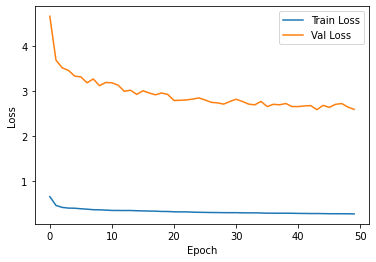

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses_LightGCN, label='Train Loss')
plt.plot(val_losses_LightGCN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
model.load_state_dict(torch.load(best_model_path_LightGCN))
test_loss, test_precision, test_recall = test_LightGCN(test_edge_index, k=20)
print(f'Test Precision@20: {test_precision:.4f}, Test Recall@20: {test_recall:.4f}')

Test Precision@20: 0.0887, Test Recall@20: 0.2531
